# Costs and Geolocation

In [26]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

PATHNAME = "./datasets/"
P_VALUE = 0.05

In [7]:
sugar_coffee_df = pd.read_csv("./datasets/all_commodities.csv")

# Sugar and Coffee Visualizations

# Geolocation

In [27]:
# Processing data as done in EDA

Midwest = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
South = ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'Washington D.C.', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas']
West = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
East = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania']

data_path = "./datasets/acs_5yr_est_selected_economic_characteristics_2010-2022.csv"
df = pd.read_csv(data_path)
df = df.replace('(X)', np.nan)
# Convert the Estimate column to float
# df = df.dropna(subset=['Estimate'])
df['Estimate'] = df['Estimate'].astype(str).str.replace(',', '').astype(float)

# Strip leading invisible characters from Label column
df['Label (Grouping)'] = df['Label (Grouping)'].str.lstrip()

# Create sub-dataframes for each region and analyze them
regions = {
    'Midwest': Midwest,
    'South': South,
    'West': West,
    'East': East
}

all_regions_df = pd.DataFrame()

for region_name, states in regions.items():
    
    # Create sub-dataframe for the region
    region_df = df[df['State'].isin(states)]
    
    # Filter for median household income and Population 16 years and over in labor force
    region_df = region_df[
        ((region_df['Label (Grouping)'].str.contains('Percent Unemployed')) & (region_df['Category'] == 'EMPLOYMENT STATUS')) |
        ((region_df['Label (Grouping)'].str.contains('Unemployment Rate')) & (region_df['Category'] == 'EMPLOYMENT STATUS')) |
        ((region_df['Label (Grouping)'] == 'Median household income (dollars)')) |
        ((region_df['Label (Grouping)'].str.contains('All people')) & (region_df['Category'] == 'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL'))
    ]
    region_df['Percent'] = region_df['Percent'].str.rstrip('%').astype('float')

    # Split region_df into three different dataframes
    unemployed_df = region_df[region_df['Label (Grouping)'].str.contains('Percent Unemployed') | region_df['Label (Grouping)'].str.contains('Unemployment Rate')]
    income_df = region_df[region_df['Label (Grouping)'] == 'Median household income (dollars)']
    poverty_df = region_df[region_df['Label (Grouping)'].str.contains('All people')]

    # Rename columns for clarity
    unemployed_df = unemployed_df.rename(columns={'Percent': 'Unemployment Rate'})
    income_df = income_df.rename(columns={'Estimate': 'Median Household Income'})
    poverty_df = poverty_df.rename(columns={'Percent': 'Poverty Rate'})

    # Reassign region_df to include all three dataframes
    region_df = pd.concat([unemployed_df, income_df, poverty_df])
    
    # Add Region column
    region_df['Region'] = region_name
    
    # Append to all_regions_df
    all_regions_df = pd.concat([all_regions_df, region_df], ignore_index=True)
    
all_regions_df.drop(['Percent', 'Estimate'], axis=1, inplace=True)

health = pd.read_csv('datasets/Nutrition_Physical_Activity_and_Obesity_Data.csv')
questions = [
    'Percent of adults aged 18 years and older who have obesity',
    'Percent of students in grades 9-12 who have obesity',
    'Percent of adults who engage in no leisure-time physical activity',
    'Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily',
    'Percent of adults who report consuming vegetables less than one time daily',
    'Percent of students in grades 9-12 who consume vegetables less than 1 time daily'
]
health = health[health['Question'].isin(questions)]
health.dropna(subset=['Data_Value'], inplace=True)

for question in questions:
    count = health[health['Question'] == question].shape[0]
# Create dictionaries to store regional dataframes
regional_dfs = {
    'Midwest': pd.DataFrame(),
    'South': pd.DataFrame(),
    'West': pd.DataFrame(),
    'East': pd.DataFrame()
}

# Function to determine region for a given state
def get_region(state):
    if state in Midwest:
        return 'Midwest'
    elif state in South:
        return 'South'
    elif state in West:
        return 'West'
    elif state in East:
        return 'East'
    else:
        return None

# Add a 'Region' column to the health dataframe
health['Region'] = health['LocationDesc'].apply(get_region)

# Filter and split the dataframe for each region
for region in regional_dfs.keys():
    regional_dfs[region] = health[health['Region'] == region][['YearStart', 'LocationDesc', 'Question', 'Data_Value']]



Resulting columns: Index(['Region', 'State', 'Year', 'Adult Obesity Rate',
       'Percent of adults who engage in no leisure-time physical activity',
       'Percent of adults who report consuming vegetables less than one time daily',
       'Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily',
       'Percent of students in grades 9-12 who consume vegetables less than 1 time daily',
       'Student Obesity Rate'],
      dtype='object')

Correlations for Midwest:
                         Poverty Rate  Median Household Income  \
Poverty Rate                 1.000000                -0.746489   
Median Household Income     -0.746489                 1.000000   
Unemployment Rate            0.751909                -0.538197   
Adult Obesity Rate          -0.056126                 0.168695   
Student Obesity Rate        -0.214825                 0.389219   

                         Unemployment Rate  Adult Obesity Rat

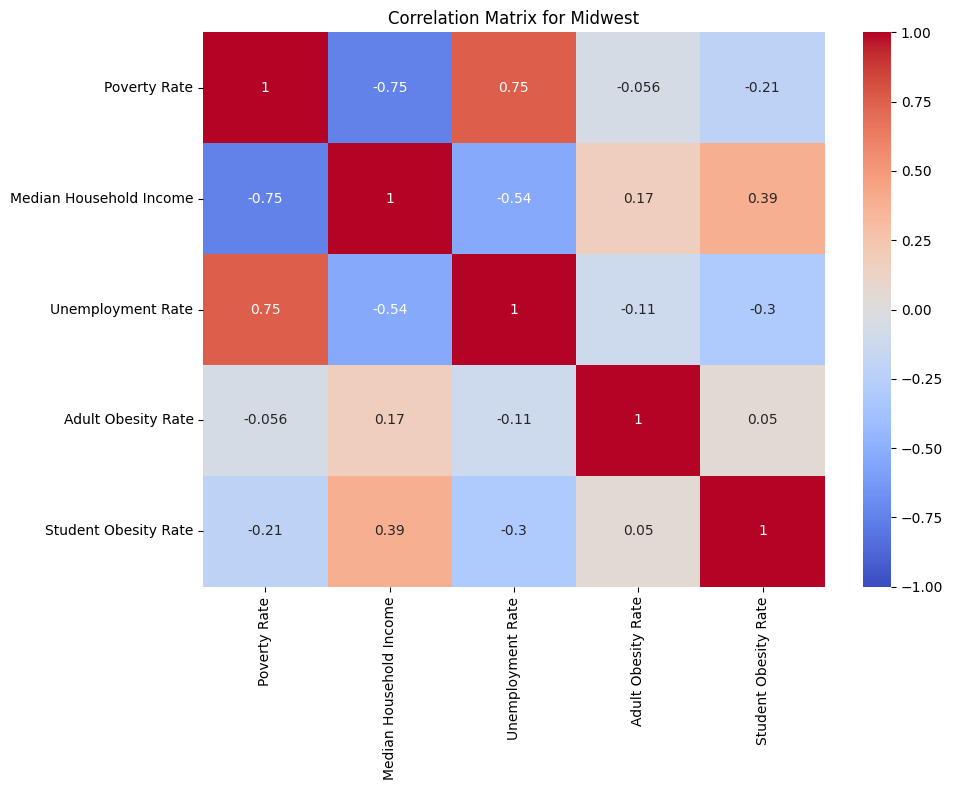

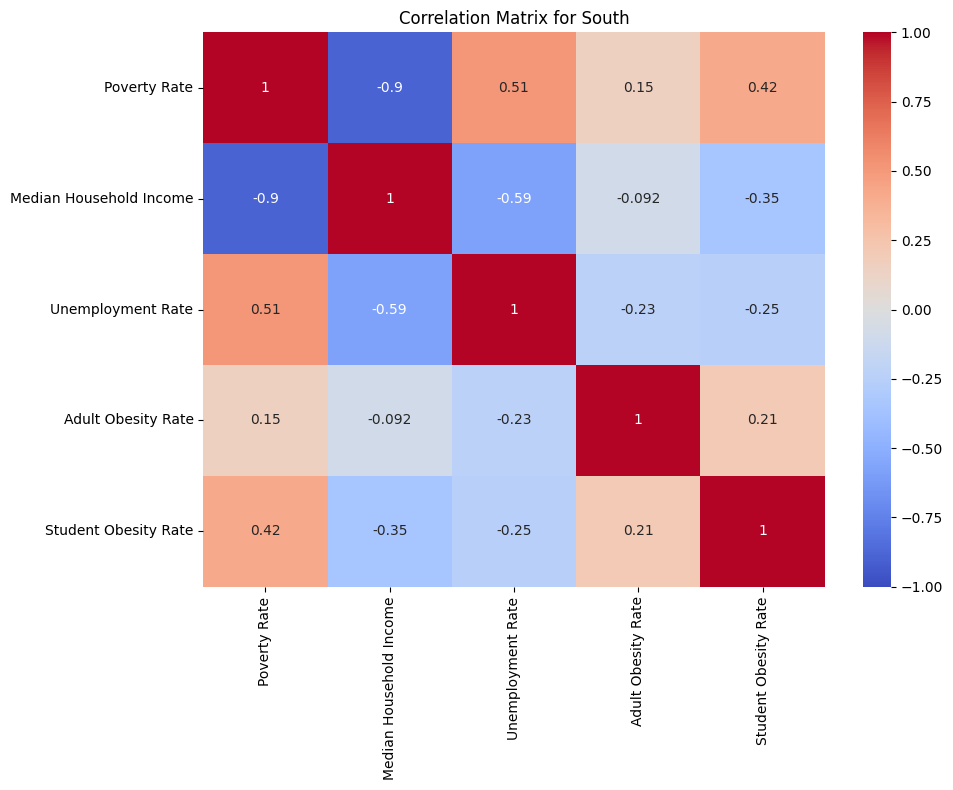

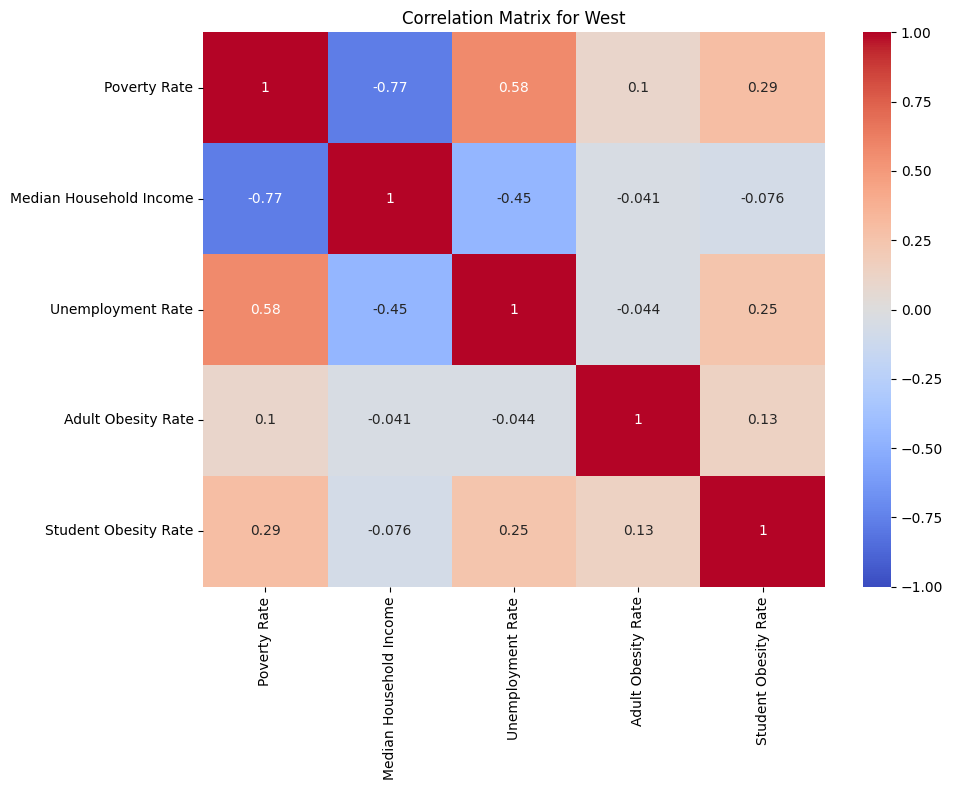

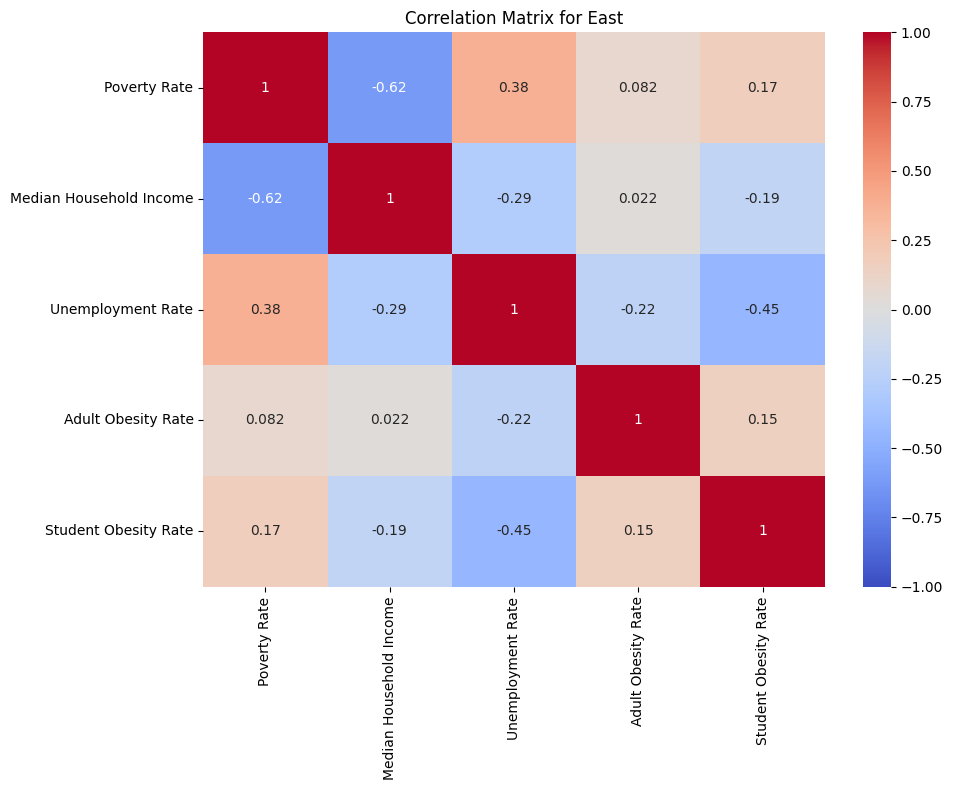

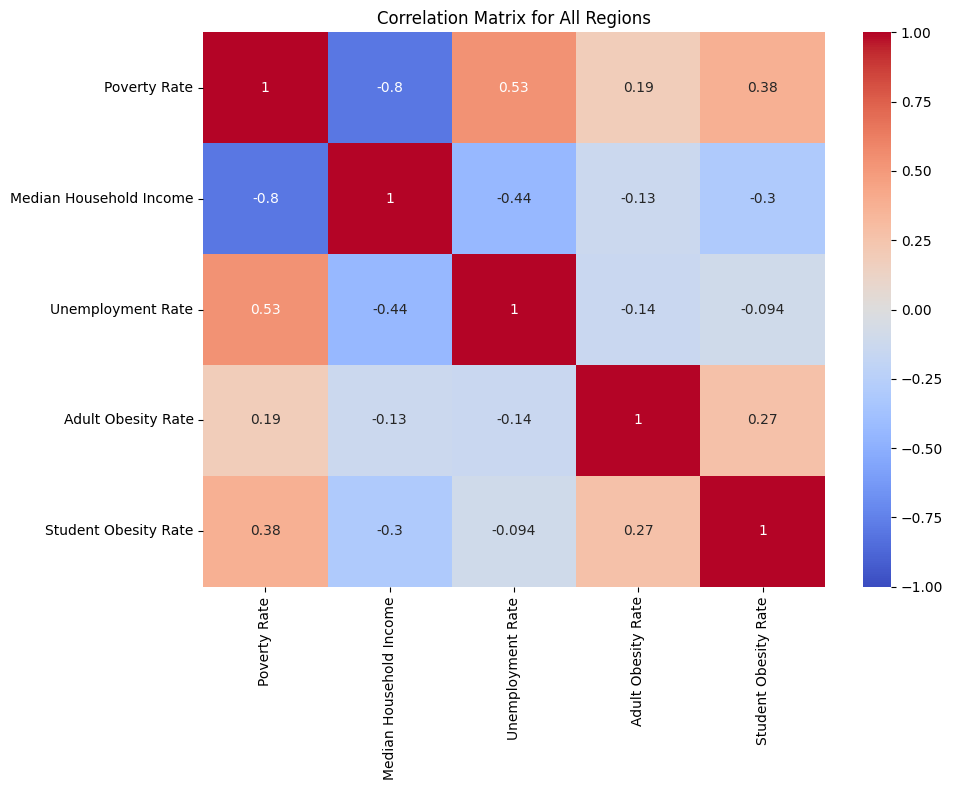

In [37]:
# Step 1: Prepare the economic data
economic_data = all_regions_df.pivot_table(
    values=['Unemployment Rate', 'Median Household Income', 'Poverty Rate'],
    index=['Region', 'State', 'Year'],
    aggfunc='first'
).reset_index()

# Step 2: Prepare the health data
health_data = pd.concat(regional_dfs.values())

# Pivot table with correct column names
health_data = health_data.pivot_table(
    values='Data_Value',
    index=['LocationDesc', 'YearStart'],
    columns='Question',
    aggfunc='first'
).reset_index()

health_data.columns.name = None
health_data = health_data.rename(columns={
    'LocationDesc': 'State',
    'YearStart': 'Year',
    'Percent of adults aged 18 years and older who have obesity': 'Adult Obesity Rate',
    'Percent of students in grades 9-12 who have obesity': 'Student Obesity Rate'
})

# Add the Region column back
def get_region(state):
    if state in Midwest:
        return 'Midwest'
    elif state in South:
        return 'South'
    elif state in West:
        return 'West'
    elif state in East:
        return 'East'
    else:
        return None

health_data['Region'] = health_data['State'].apply(get_region)

# Reorder columns to put Region first
cols = health_data.columns.tolist()
cols = ['Region'] + [col for col in cols if col != 'Region']
health_data = health_data[cols]

# Print the resulting columns to verify
print("Resulting columns:", health_data.columns)

# Step 3: Merge the datasets
merged_data = pd.merge(
    economic_data,
    health_data[['Region', 'State', 'Year', 'Adult Obesity Rate', 'Student Obesity Rate']],
    on=['Region', 'State', 'Year'],
    how='inner'
)

# Step 4: Calculate correlations for each region
correlations = {}

for region in ['Midwest', 'South', 'West', 'East']:
    region_data = merged_data[merged_data['Region'] == region]
    
    variables = ['Poverty Rate', 'Median Household Income', 'Unemployment Rate', 'Adult Obesity Rate', 'Student Obesity Rate']
    region_correlations = region_data[variables].corr()
    
    correlations[region] = region_correlations

# Print correlations for each region
for region, corr_matrix in correlations.items():
    print(f"\nCorrelations for {region}:")
    print(corr_matrix)

correlation_matrix = merged_data[['Poverty Rate', 'Median Household Income', 'Unemployment Rate', 'Adult Obesity Rate', 'Student Obesity Rate']].corr()

def create_and_save_heatmap(correlation_matrix, region, output_path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix for {region}')
    plt.tight_layout()
    plt.savefig(output_path)

# Create and save heatmaps for each region
for region, corr_matrix in correlations.items():
    output_path = f'correlation_heatmap_{region}.png'
    create_and_save_heatmap(corr_matrix, region, output_path)
    print(f"Heatmap for {region} saved as {output_path}")
    print(corr_matrix)

# If you want to create a single heatmap for all regions combined:
all_regions_corr = merged_data[['Poverty Rate', 'Median Household Income', 'Unemployment Rate', 'Adult Obesity Rate', 'Student Obesity Rate']].corr()
create_and_save_heatmap(all_regions_corr, 'All Regions', 'correlation_heatmap_all_regions.png')
print("Heatmap for all regions combined saved as correlation_heatmap_all_regions.png")
